# Imports / Setup

In [150]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

df = pd.read_csv("data/train.csv", parse_dates=["Dates"])
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


# Preprocessing

Since there are no empty rows in any column, we can proceed with our analysis without removing any of the missing data rows.

However, we will need to convert the date strings into something more useful, such as separate columns for year, month, day, hour, and day of the week.

Also, cyclic time features are useful for the models to understand time patterns better ([source](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)).

In [151]:
print("Empty Rows per Column:")
print(df.isnull().sum())

df["Year"] = df["Dates"].dt.year
df["Month"] = df["Dates"].dt.month
df["Day"] = df["Dates"].dt.day
df["Hour"] = df["Dates"].dt.hour

df["hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

cat_counts = df["Category"].value_counts()
keep_categories = cat_counts[cat_counts >= 2].index
before_n = len(df)
df = df[df["Category"].isin(keep_categories)].copy()
after_n = len(df)

df.head()

Empty Rows per Column:
Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,hour_sin,hour_cos,month_sin,month_cos
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,-0.258819,0.965926,0.5,-0.866025
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,-0.258819,0.965926,0.5,-0.866025
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,-0.258819,0.965926,0.5,-0.866025
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,-0.258819,0.965926,0.5,-0.866025
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,-0.258819,0.965926,0.5,-0.866025


# Building Models

For the "predict the type of crime based on location, time, and/or other features", we chose the `DecisionTreeClassifier` model

For the "predict the district based on crime characteristics", we chose the `BernoulliNB` model, as it was slightly more accurate than the `ComplementNB` model.

In [152]:
x_cat = df[["DayOfWeek", "PdDistrict", "X", "Y", "Hour", "Month"]]
y_cat = df["Category"]

pre_cat = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["DayOfWeek", "PdDistrict"]),
        ("num", "passthrough", ["X", "Y", "Hour", "Month"]),
    ],
    remainder="drop",
)

dt = DecisionTreeClassifier(
    max_depth=14,
    min_samples_leaf=2,
    random_state=42
)

pipe_dt = Pipeline([("pre", pre_cat), ("clf", dt)])

In [153]:
x_dist = df[["Category", "DayOfWeek", "Month", "Day", "Hour"]].copy()
y_dist = df["PdDistrict"].copy()

pre_dist_bnb = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         ["Category", "DayOfWeek", "Month", "Day", "Hour"]),
    ],
    remainder="drop",
)

pipe_bnb = Pipeline([("pre", pre_dist_bnb), ("clf", BernoulliNB())])

# Training Models

In [154]:
def eval_model(model, x, y):
    class_counts = y.value_counts() if hasattr(y, 'value_counts') else pd.Series(y).value_counts()
    use_stratify = class_counts.min() >= 2
    if not use_stratify:
        print('Warning: some classes have fewer than 2 samples; falling back to non-stratified split')
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
    m = clone(model)
    m.fit(x_train, y_train)  # pyright: ignore[reportAttributeAccessIssue]
    y_pred = m.predict(x_test)  # pyright: ignore[reportAttributeAccessIssue]
    return accuracy_score(y_test, y_pred)

In [155]:
print(f"Decision Tree Accuracy: {(eval_model(pipe_dt, x_cat, y_cat)):.2%}")
print(f"Naïve Bayes Accuracy: {(eval_model(pipe_bnb, x_dist, y_dist)):.2%}")

Decision Tree Accuracy: 26.81%
Naïve Bayes Accuracy: 20.35%


# Crime Density Heatmap

This is mainly just for visualization purposes, it isn't required for the assignment, but it's interesting to see the data like this.

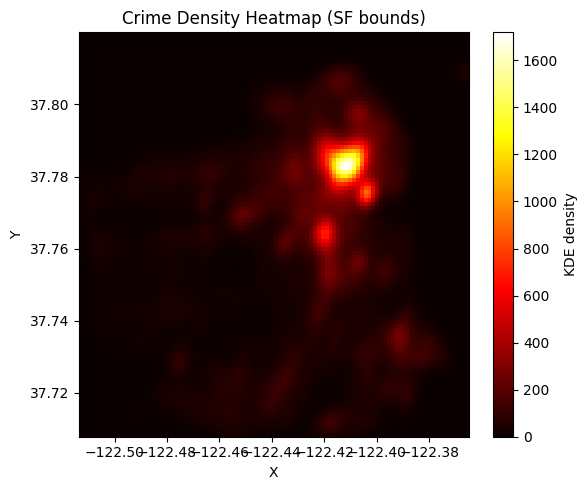

In [156]:
sf = df[
    (df["X"] >= -122.52) & (df["X"] <= -122.35) & (df["Y"] >= 37.70) & (df["Y"] <= 37.83)
].copy()

x_min, x_max = sf["X"].min(), sf["X"].max()
y_min, y_max = sf["Y"].min(), sf["Y"].max()

xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([sf["X"].values, sf["Y"].values])  # pyright: ignore[reportCallIssue, reportArgumentType]

kde = gaussian_kde(values)
f = np.reshape(kde(positions).T, xx.shape)

plt.figure(figsize=(6, 5))
plt.imshow(
    np.rot90(f),
    cmap="hot",
    extent=[x_min, x_max, y_min, y_max],  # pyright: ignore[reportArgumentType]
    aspect="auto",
)
plt.colorbar(label="KDE density")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Crime Density Heatmap (SF bounds)")
plt.tight_layout()
plt.show()